In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *

from lie import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

Setting environment for Gordon


In [3]:
stack = 'MD589'

In [4]:
# Load atlasProjected volume

atlasProjected_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_atlasProjectedVolume.bp' % {'stack': stack}))

available_labels_sided = [labels_sided[i-1] for i in np.unique(atlasProjected_volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [29]:
def parallel_where(name, num_samples=None):
    global atlasProjected_volume, labels_sided_indices
    
    w = np.where(atlasProjected_volume == labels_sided_indices[name])
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlasProjected_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(name_s, num_samples=int(1e5)) 
                                         for name_s in available_labels_sided)
atlasProjected_nzs = dict(zip(available_labels_sided, atlasProjected_nzs))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

load atlas: 211.016330 seconds


In [30]:
atlasProjected_centroid = {name: nzs.mean(axis=0) for name, nzs in atlasProjected_nzs.iteritems()}
atlasProjected_pts_centered = {name: nzs - atlasProjected_centroid[name] for name, nzs in atlasProjected_nzs.iteritems()}
test_centroid = atlasProjected_centroid.copy()

In [34]:
params_dir = create_if_not_exists(atlasAlignParams_rootdir + '/' + stack)

In [8]:
# Load score volumes

t = time.time()

volume2_allLabels = {}

for name in available_labels_unsided:
    
    if name == 'BackG':
        continue

    volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                      {'stack': stack, 'label': name})).astype(np.float16)
    volume2_allLabels[name] = volume2_roi
    del volume2_roi

test_ydim, test_xdim, test_zdim = volume2_allLabels.values()[0].shape

print test_xdim, test_ydim, test_zdim

# test_xdim = volume_xmax - volume_xmin + 1
# test_ydim = volume_ymax - volume_ymin + 1
# test_zdim = volume_zmax - volume_zmin + 1

sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))

838 460 454


load score volumes: 41.484492 seconds


In [9]:
########### Load Gradient ###########

dSdxyz = {name: np.empty((3, test_ydim, test_xdim, test_zdim), dtype=np.float16) for name in available_labels_unsided}

t1 = time.time()

for name in available_labels_unsided:
    
    if name == 'BackG':
        continue

    t = time.time()
    
    dSdxyz[name][0] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gx.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][1] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gy.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][2] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gz.bp' % {'stack':stack, 'label':name})
    
    sys.stderr.write('load gradient %s: %f seconds\n' % (name, time.time() - t)) # ~7s

sys.stderr.write('overall: %f seconds\n' % (time.time() - t1)) # 140s

load gradient RtTg: 17.033388 seconds
load gradient VLL: 25.860550 seconds
load gradient Tz: 31.395885 seconds
load gradient LC: 26.586666 seconds
load gradient 7N: 25.483964 seconds
load gradient Amb: 27.088956 seconds
load gradient 6N: 20.943968 seconds
load gradient AP: 29.013094 seconds
load gradient 5N: 25.950006 seconds
load gradient 12N: 26.522911 seconds
load gradient 7n: 24.793848 seconds
load gradient R: 20.719068 seconds
load gradient Pn: 23.181845 seconds
load gradient LRt: 26.183156 seconds
overall: 350.763425 seconds


In [57]:
def step_lie(T, name, lr, dMdv_historical, verbose=False, num_samples=1000):
    """
    One optimization step over Lie group SE(3).
    
    T: flattened 1x12 vector of 3x4 transform matrix
    name: landmark class label
    lr: learning rate
    """
    
    name_unsided = labelMap_sidedToUnsided[name]
        
    pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered[name], 
                                 c_prime=test_centroid[name]).astype(np.int16)
    
    xs_prime, ys_prime, zs_prime = pts_prime.T
        
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
    
    if verbose:
        print 'nz', np.count_nonzero(valid) 
        
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name
    
    xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T
        
        
    voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    if num_samples is not None:
        # sample some voxels # this seems to make optimization more stable than using all voxels
        n = np.count_nonzero(valid)
        ii = np.random.choice(range(n), min(num_samples, n), replace=False)
        
        dSdx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]        
        dSdy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        dSdz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        
        xss = xs_prime_valid.astype(np.float)[ii]
        yss = ys_prime_valid.astype(np.float)[ii]
        zss = zs_prime_valid.astype(np.float)[ii]
        
    else:
        # use all voxels    
        dSdx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        xss = xs_prime_valid.astype(np.float)
        yss = ys_prime_valid.astype(np.float)
        zss = zs_prime_valid.astype(np.float)

    #############################################
    
    q = np.c_[dSdx, dSdy, dSdz, -dSdy*zss + dSdz*yss, dSdx*zss - dSdz*xss, -dSdx*yss + dSdy*xss]
    
    dMdv = q.sum(axis=0)

    if verbose:
        print 'q:', q
        print 'dMdv:', dMdv
        print 'score:', score

#     lr = np.array([0, 0, 0, 0, 0, 1e-2])
#     global dMdv_historical
    dMdv_historical += dMdv**2
    dMdv_adjusted = dMdv / (1e-10 + np.sqrt(dMdv_historical))
    v_opt = lr * dMdv_adjusted # no minus sign because maximizing

#     global iteration
#     lr = np.array([0, 0, 0, 0, 0, 1e-7])
#     v_opt = lr * np.exp(-iteration/1000.) * dMdv # no minus sign because maximizing
#     v_opt = lr * dMdv # no minus sign because maximizing

    if verbose:
        print 'v_opt:', v_opt

    theta = np.sqrt(np.sum(v_opt[3:]**2))
    if verbose:
        print 'theta:', theta
    assert theta < np.pi
        
    exp_w, Vt = matrix_exp_v(v_opt)
    
    if verbose:
        print 'Vt:' , Vt
    
    Tm = np.reshape(T, (3,4))
    t = Tm[:, 3]
    R = Tm[:, :3]
                        
    R_new = np.dot(exp_w, R)
    t_new = np.dot(exp_w, t) + Vt
    
    if verbose:
        print '\n'

    return np.column_stack([R_new, t_new]).flatten(), score, dMdv_historical

In [55]:
def compute_score(T, name, surround=False):
        
    name_unsided = labelMap_sidedToUnsided[name]
    
    if not surround:
        pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered[name], 
                                     c_prime=test_centroid[name]).astype(np.int16)
        print atlasProjected_pts_centered[name].mean(axis=0), test_centroid[name]
        print T
    else:
        pts_prime = transform_points(T, pts_centered=surr_pts_centered[name], 
                                     c_prime=test_centroid[name]).astype(np.int16)
                
    xs_prime, ys_prime, zs_prime = pts_prime.T
    
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name
#     print np.count_nonzero(valid) 
    xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T
    
    voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    return score

def compute_score_and_gradient(T, name, surround=False, num_samples=None):
    """
    Compute score and gradient.
    """
    
    name_unsided = labelMap_sidedToUnsided[name]

    if not surround:
        pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered[name], 
                                     c_prime=test_centroid[name]).astype(np.int16)
    else:
        pts_prime = transform_points(T, pts_centered=surr_pts_centered[name], 
                                     c_prime=test_centroid[name]).astype(np.int16)

    xs_prime, ys_prime, zs_prime = pts_prime.T

    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name

    xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T

    voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    if num_samples is not None:
    
        n = np.count_nonzero(valid)
        ii = np.random.choice(range(n), min(int(num_samples), n), replace=False)
    
        Sx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        Sy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        Sz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        
        if not surround:
            dxs, dys, dzs = atlasProjected_pts_centered[name][valid][ii].T
        else:
            dxs, dys, dzs = surr_pts_centered[name][valid][ii].T
            
    else:

        Sx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        if not surround:
            dxs, dys, dzs = atlasProjected_pts_centered[name][valid].T
        else:
            dxs, dys, dzs = surr_pts_centered[name][valid].T

    dMdA = np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                  Sy*dxs, Sy*dys, Sy*dzs, Sy,
                  Sz*dxs, Sz*dys, Sz*dzs, Sz].sum(axis=0)
    
    return score, dMdA


def step_gd(T, name, lr, dMdA_historical, surround=False, surround_weight=2., num_samples=None):
    """
    One optimization step using gradient descent with Adagrad.
    
    T: flattened 1x12 vector of 3x4 transform matrix.
    name: landmark class label
    lr: learning rate
    """
    
    score, dMdA = compute_score_and_gradient(T, name, num_samples=num_samples)
    
    if surround:
        s_surr, dMdA_surr = compute_score_and_gradient(T, name, surround=True, num_samples=num_samples)
        dMdA -= surround_weight * dMdA_surr
        score -= surround_weight * s_surr
        
    dMdA_historical += dMdA**2
    dMdA_adjusted = dMdA / (1e-10 + np.sqrt(dMdA_historical))

    new_T = T + lr*dMdA_adjusted
    
    return new_T, score, dMdA_historical

In [27]:
surr_nzs = get_surround_voxels(atlasProjected_volume, fill=True)
surr_nzs = {labels_sided[name_s_ind]: nzs for name_s_ind, nzs in surr_nzs.iteritems() 
            if labels_sided[name_s_ind] in available_labels_sided}
surr_pts_centered = {name: nzs - test_centroid[name] for name, nzs in surr_nzs.iteritems()}

Setting environment for Gordon
5N_R


[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]


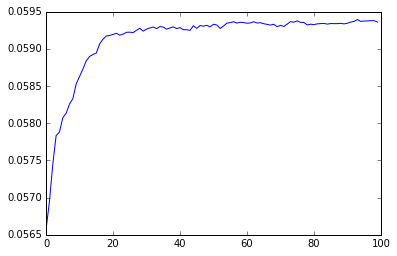

[[ 0.99720292 -0.04625257 -0.0587114  -1.70551772]
 [ 0.0420384   0.99658372 -0.07108906  1.34366983]
 [ 0.06179888  0.06842209  0.99574059  6.70434084]]


In [61]:
history_len = 200
T0 = np.array([1,0,0,0,0,1,0,0,0,0,1,0])
max_iter = 100

# for name_of_interest in available_labels_sided:
for name_of_interest in ['5N_R']:

    if name_of_interest == 'BackG' or name_of_interest == 'outerContour':
        continue
    
    print name_of_interest
    
    # set the rotation center of both atlas and test volume to the landmark centroid after affine projection
    
#     global atlasProjected_centroid, test_centroid, atlasProjected_pts_centered
        
#     atlasProjected_centroid = atlasProjected_nzs[name_of_interest].mean(axis=0)
#     test_centroid = atlasProjected_centroid[name_of_interest].copy()
    
    ############ gradient descent ############

    dMdv_historical = np.zeros((6,))
#     dMdA_historical = np.zeros((12,))

    score_best = 0
    scores = []
    
    T = T0.copy()

    for iteration in range(max_iter):
        
        T, s, dMdv_historical = step_lie(T, name=name_of_interest, lr=np.array([1,1,1,1e-2,1e-2,1e-2]), 
                        dMdv_historical=dMdv_historical, verbose=False, num_samples=10000)

#         lr1, lr2 = (1., 1e-2)
#         lr = np.r_[lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1]
#         T, s, dMdA_historical = step_gd(T, name=name_of_interest, lr=lr, dMdA_historical=dMdA_historical,
#                                        surround=True, surround_weight=2.)
        
#         success = False
#         c = 0
#         while not success and c < 10:
#             try:
#                 c += 1
#                 T, s = step(T, name=name_of_interest, lr=np.array([1,1,1,1e-2,1e-2,1e-2]), verbose=True,
#                             num_samples=None)
#                 success = True
#             except:
#                 pass
            
        scores.append(s)

        if iteration > 2*history_len:
            if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                      np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-5:
                break

        if s > score_best:
            best_gradient_descent_params = T
            score_best = s
    
    plt.plot(scores);
    plt.show();
    
    print best_gradient_descent_params.reshape((3,4))
    
#     np.save(atlasAlignOptLogs_dir + '/%(stack)s_%(name)s_scoreEvolutions_transformUponAffineProjection.npy' % \
#             {'stack':stack, 'name': name_of_interest}, scores)
    
#     with open(params_dir + '/%(stack)s_%(name)s_transformUponAffineProjection.txt' % {'stack': stack, 'name': name_of_interest}, 
#               'w') as f:
#         f.write((' '.join(['%f']*12)+'\n') % tuple(best_gradient_descent_params))
#         f.write((' '.join(['%d']*3)+'\n') % tuple(np.r_[test_xdim, test_ydim, test_zdim]))
#         f.write((' '.join(['%.1f']*3)+'\n') % tuple(atlasProjected_centroid[name_of_interest]))
#         f.write((' '.join(['%.1f']*3)+'\n') % tuple(test_centroid[name_of_interest]))